In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from cmcrameri import cm
from matplotlib import colors
import matplotlib.patches as patches
from scipy import signal
import peakutils
import math

In [2]:
EXPERIMENT_DIR = '/data2/experiments/P3856'
RUN_NAME = 'P3856_YHE211_1_Slot1-1_1_5104'
EXPERIMENT_NAME = 'P3856'

In [451]:
# cuboids_df = pd.read_pickle('{}/precursor-cuboids-3did/exp-{}-run-{}-mz-100-1700-precursor-cuboids.pkl'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME))
cuboids_df = pd.read_pickle('{}/precursor-cuboids-3did/exp-{}-run-{}-mz-600-800-precursor-cuboids.pkl'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME))
cuboids_df.sort_values(by=['anchor_point_intensity'], ascending=False, inplace=True)
cuboids_df.reset_index(drop=True, inplace=True)


In [452]:
MS1_PEAK_DELTA = 0.1

In [453]:
len(cuboids_df)

957

In [454]:
cuboids_df[cuboids_df.anchor_point_intensity > 500].tail(10)

,mz_lower,mz_upper,scan_lower,scan_upper,rt_lower,rt_upper,anchor_point_intensity,anchor_point_mz,anchor_point_scan,anchor_point_retention_time_secs,anchor_point_frame_id,number_of_isotope_clusters,number_of_isotopes,precursor_cuboid_id
947,713.604554,715.373576,571,596,2065.665493,2075.665493,504.0,714.166044,586.0,2070.665493,18582.0,2,4,461
948,755.255511,756.152243,583,658,2026.214212,2034.681085,504.0,755.690877,620.0,2029.389267,18192.0,4,3,673
949,615.312373,616.877221,732,745,2157.229798,2167.229798,503.0,615.549697,743.0,2162.229798,19447.0,1,7,52
950,663.809034,665.365571,658,690,2173.344237,2180.751692,503.0,663.857522,684.0,2177.577791,19592.0,1,4,278
951,733.817105,734.985858,531,581,2082.836165,2090.779963,503.0,734.390740,542.0,2087.074237,18737.0,1,3,556
952,757.420647,758.944998,458,498,2135.770232,2143.707733,503.0,757.930033,476.0,2140.003693,19237.0,2,4,674
953,727.775740,730.409673,568,650,2178.929619,2188.929619,503.0,728.359707,612.0,2183.929619,19652.0,3,8,555
954,774.394975,776.408177,459,545,2174.403644,2180.751692,503.0,774.870745,478.0,2177.577791,19592.0,3,5,813
955,724.707425,726.392928,551,625,2154.290071,2160.111912,502.0,724.893199,570.0,2157.464479,19402.0,2,4,557
956,766.724346,768.114585,638,668,2026.214212,2035.210094,501.0,767.102192,659.0,2030.976810,18207.0,1,5,814


In [724]:
cuboid_s = cuboids_df.loc[936]

In [725]:
mz_lower = cuboid_s.mz_lower
mz_upper = cuboid_s.mz_upper
scan_lower = cuboid_s.scan_lower
scan_upper = cuboid_s.scan_upper
rt_lower = cuboid_s.rt_lower
rt_upper = cuboid_s.rt_upper

In [726]:
ap_intensity = int(cuboid_s.anchor_point_intensity)
ap_mz = cuboid_s.anchor_point_mz
ap_scan = int(cuboid_s.anchor_point_scan)
ap_rt = cuboid_s.anchor_point_retention_time_secs
ap_frame_id = int(cuboid_s.anchor_point_frame_id)

In [727]:
ap_peak_mz_lower = ap_mz-MS1_PEAK_DELTA
ap_peak_mz_upper = ap_mz+MS1_PEAK_DELTA

In [728]:
SCAN_OFFSET_LOWER = 100
SCAN_OFFSET_UPPER = 100
MZ_OFFSET_LOWER = 0.5
MZ_OFFSET_UPPER = 0.5
RT_OFFSET_LOWER = 5.0
RT_OFFSET_UPPER = 5.0

In [729]:
wide_mz_lower = mz_lower - MZ_OFFSET_LOWER
wide_mz_upper = mz_upper + MZ_OFFSET_UPPER
wide_scan_lower = scan_lower - SCAN_OFFSET_LOWER
wide_scan_upper = scan_upper + SCAN_OFFSET_UPPER
wide_rt_lower = rt_lower - RT_OFFSET_LOWER
wide_rt_upper = rt_upper + RT_OFFSET_UPPER

In [730]:
# frame types for PASEF mode
FRAME_TYPE_MS1 = 0
FRAME_TYPE_MS2 = 8

In [731]:
INTENSITY_THRESHOLD = 50

In [732]:
converted_db_name = '{}/converted-databases/exp-{}-run-{}-converted.sqlite'.format(EXPERIMENT_DIR, EXPERIMENT_NAME, RUN_NAME)

In [733]:
db_conn = sqlite3.connect(converted_db_name)
wide_cuboid_points_df = pd.read_sql_query("select * from frames where frame_type == {} and mz >= {} and mz <= {} and scan >= {} and scan <= {} and retention_time_secs >= {} and retention_time_secs <= {} and intensity >= {}".format(FRAME_TYPE_MS1, wide_mz_lower, wide_mz_upper, wide_scan_lower, wide_scan_upper, wide_rt_lower, wide_rt_upper, INTENSITY_THRESHOLD), db_conn)
db_conn.close()

In [734]:
cuboid_points_df = wide_cuboid_points_df[(wide_cuboid_points_df.mz >= mz_lower) & (wide_cuboid_points_df.mz <= mz_upper) & (wide_cuboid_points_df.scan >= scan_lower) & (wide_cuboid_points_df.scan <= scan_upper) & (wide_cuboid_points_df.retention_time_secs >= rt_lower) & (wide_cuboid_points_df.retention_time_secs <= rt_upper)]


In [735]:
wide_cuboid_points_ap_frame_df = wide_cuboid_points_df[(wide_cuboid_points_df.frame_id == ap_frame_id)]

In [736]:
wide_cuboid_points_df.sort_values(by=['intensity'], ascending=True, inplace=True)

In [737]:
# create the colour map to convert intensity to colour
colour_map = cm.batlow_r
norm = colors.LogNorm(vmin=100, vmax=1000, clip=True)


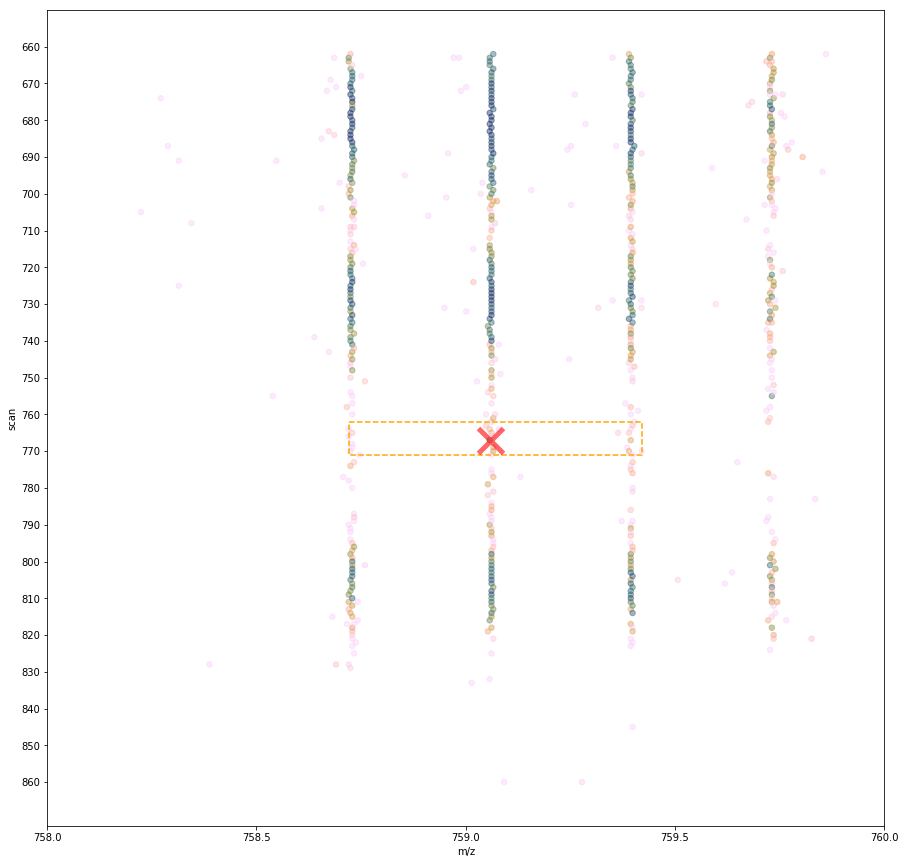

In [738]:
f, ax1 = plt.subplots()
f.set_figheight(15)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_cuboid_points_ap_frame_df.mz, wide_cuboid_points_ap_frame_df.scan, c=wide_cuboid_points_ap_frame_df.intensity, cmap=colour_map, norm=norm, alpha=0.4, s=30, linewidths=None, edgecolors=None)
plt.plot(ap_mz, ap_scan, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, alpha=0.6, label='anchor point')

# draw the cuboid extent
top_left = (mz_lower,scan_lower)
width = mz_upper - mz_lower
height = scan_upper - scan_lower
cuboid_rect = patches.Rectangle(top_left,width,height,linewidth=1.5,linestyle='--',edgecolor='orange',facecolor='none')
ax1.add_patch(cuboid_rect)

plt.xlabel("m/z")
plt.ylabel("scan")

nearest = 0.5
range_l = round(wide_cuboid_points_ap_frame_df.mz.min() / nearest) * nearest
range_u = round(wide_cuboid_points_ap_frame_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

nearest = 10.0
range_l = round(wide_cuboid_points_ap_frame_df.scan.min() / nearest) * nearest
range_u = round(wide_cuboid_points_ap_frame_df.scan.max() / nearest) * nearest
plt.yticks(np.arange(range_l,range_u+nearest,nearest))

# plt.xlim([wide_mz_lower, wide_mz_upper])
# plt.ylim([wide_scan_lower, wide_scan_upper])

plt.gca().invert_yaxis()
plt.show()

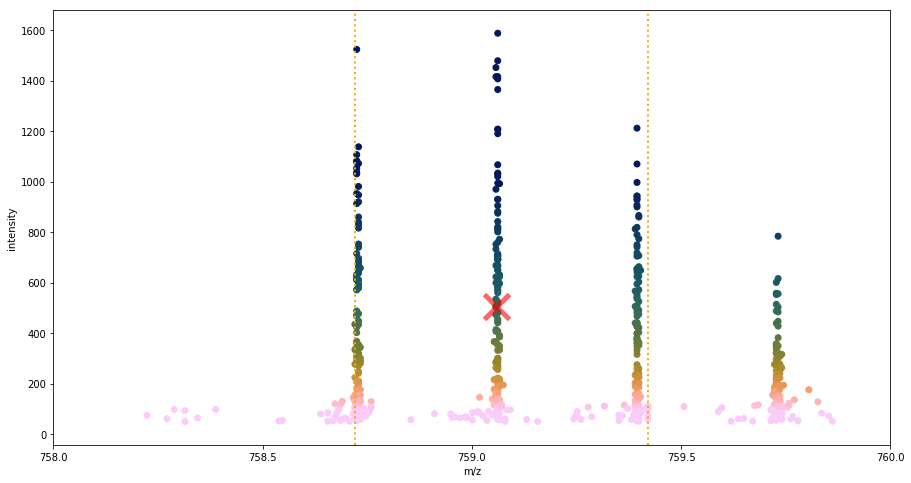

In [739]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_cuboid_points_ap_frame_df.mz, wide_cuboid_points_ap_frame_df.intensity, c=wide_cuboid_points_ap_frame_df.intensity, cmap=colour_map, norm=norm)
plt.axvline(x=mz_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=mz_upper, linestyle=':', color='orange', linewidth=2)
plt.plot(ap_mz, ap_intensity, marker='x', markerfacecolor='none', markeredgecolor='red', linestyle='', markeredgewidth=5, ms=25, label='anchor point', alpha=0.6)

plt.xlim([wide_mz_lower, wide_mz_upper])

nearest = 0.5
range_l = round(wide_cuboid_points_ap_frame_df.mz.min() / nearest) * nearest
range_u = round(wide_cuboid_points_ap_frame_df.mz.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlabel("m/z")
plt.ylabel("intensity")
plt.show()

In [740]:
# constrain the plots to the monoisotopic peak
ap_peak_points_df = wide_cuboid_points_df[(wide_cuboid_points_df.mz >= ap_peak_mz_lower) & (wide_cuboid_points_df.mz <= ap_peak_mz_upper)]


In [741]:
wide_scan_df = ap_peak_points_df.groupby(['scan'], as_index=False).intensity.sum()
wide_scan_df.sort_values(by=['scan'], ascending=True, inplace=True)

In [742]:
len(wide_scan_df)

182

In [743]:
# determine the maximum filter length for the number of points
def find_filter_length(number_of_points):
    filter_lengths = [51,11,5]  # must be a positive odd number, greater than the polynomial order, and less than the number of points to be filtered
    return filter_lengths[next(x[0] for x in enumerate(filter_lengths) if x[1] < number_of_points)]

In [744]:
# filter the points
wide_scan_df['filtered_intensity'] = wide_scan_df.intensity  # set the default
try:
    wide_scan_df['filtered_intensity'] = signal.savgol_filter(wide_scan_df.intensity, window_length=find_filter_length(number_of_points=len(wide_scan_df)), polyorder=3)
    filtered = True
except:
    filtered = False

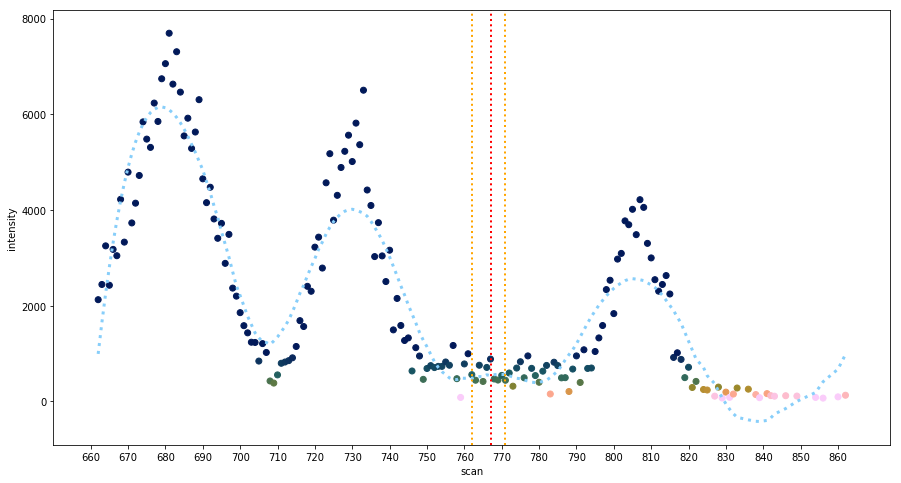

In [745]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_scan_df.scan, wide_scan_df.intensity, c=wide_scan_df.intensity, cmap=colour_map, norm=norm)
plt.plot(wide_scan_df.scan, wide_scan_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.axvline(x=scan_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=scan_upper, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=ap_scan, linestyle=':', color='red', linewidth=2)

nearest = 10
range_l = round(wide_scan_df.scan.min() / nearest) * nearest
range_u = round(wide_scan_df.scan.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlabel("scan")
plt.ylabel("intensity")
plt.show()

In [746]:
wide_rt_df = ap_peak_points_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()
wide_rt_df.sort_values(by=['frame_id','retention_time_secs'], ascending=True, inplace=True)

In [747]:
# filter the points
wide_rt_df['filtered_intensity'] = wide_rt_df.intensity  # set the default
try:
    wide_rt_df['filtered_intensity'] = signal.savgol_filter(wide_rt_df.intensity, window_length=find_filter_length(number_of_points=len(wide_rt_df)), polyorder=3)
    filtered = True
except:
    filtered = False

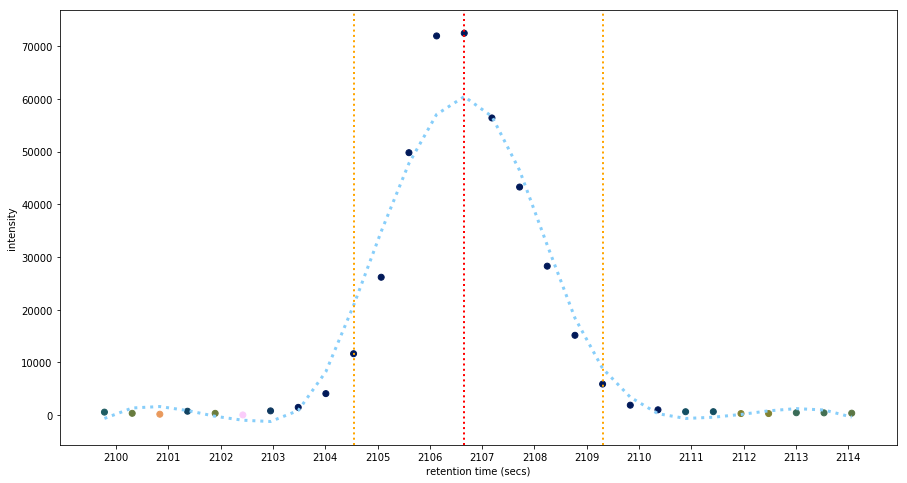

In [748]:
# plot the cluster assignments
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

plt.scatter(wide_rt_df.retention_time_secs, wide_rt_df.intensity, c=wide_rt_df.intensity, cmap=colour_map, norm=norm)
plt.plot(wide_rt_df.retention_time_secs, wide_rt_df.filtered_intensity, marker='', color='lightskyblue', linestyle=':', linewidth=3, ms=5, label='extracted')

plt.axvline(x=rt_lower, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=rt_upper, linestyle=':', color='orange', linewidth=2)
plt.axvline(x=ap_rt, linestyle=':', color='red', linewidth=2)

nearest = 1
range_l = round(wide_rt_df.retention_time_secs.min() / nearest) * nearest
range_u = round(wide_rt_df.retention_time_secs.max() / nearest) * nearest
plt.xticks(np.arange(range_l,range_u+nearest,nearest))

plt.xlabel("retention time (secs)")
plt.ylabel("intensity")
plt.show()